[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/adams/blob/master/exercises/Ex08_forecasting_financial/Ex08b_Forecasting_fin_data.ipynb)

# Forecasting financial times series with LSTM


Direct financial forecasting of times series with RNN family models still remains to reach its full potential.
At the moment, traditional statistical models like ARIMA and GARCH are often, at least, competitive to complex NN and LSTMs in particular. Do not expect great results when we apply LSTMs to stock prediction today. For illustration, we will try to develop a one-day ahead prediction of the Amazon stock (AMZN) using data of past stock movements. Feel very free to adapt the code to predict other stocks. 

Our target value will be the percentage return defined as 

$$r= \frac{x_{t+1}-x_{t}}{x_{t}}$$

**Remark:**<br>
Time series data is a specific form of sequential data, and stock data may be considered a special type of time series data. Applying a LSTM to stock prediction is a nontrivial task. 

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/crajapax/GDAtrack3b/main/AMZN.csv",sep=",") 
#data = pd.read_csv("../../data/TSPrep.csv",sep="\t") 
data.tail(10) 

,Date,Open,High,Low,Close,Adj Close,Volume
2759,2020-03-17,1775.469971,1857.780029,1689.239990,1807.839966,1807.839966,10917100
2760,2020-03-18,1750.000000,1841.660034,1745.000000,1830.000000,1830.000000,9645200
2761,2020-03-19,1860.000000,1945.000000,1832.650024,1880.930054,1880.930054,10399900
2762,2020-03-20,1926.310059,1957.000000,1820.729980,1846.089966,1846.089966,9817900
2763,2020-03-23,1827.750000,1919.400024,1812.000000,1902.829956,1902.829956,7808500
2764,2020-03-24,1951.500000,1955.000000,1900.339966,1940.099976,1940.099976,7147100
2765,2020-03-25,1920.689941,1950.260010,1885.780029,1885.839966,1885.839966,6479100
2766,2020-03-26,1902.000000,1956.489990,1889.290039,1955.489990,1955.489990,6221300
2767,2020-03-27,1930.859985,1939.790039,1899.920044,1900.099976,1900.099976,5387900
2768,2020-03-30,1922.829956,1973.630005,1912.339966,1963.949951,1963.949951,6115100


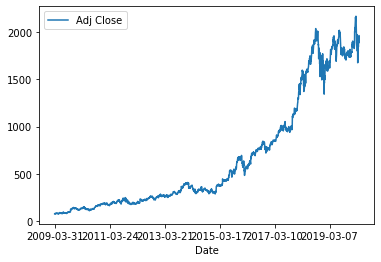

In [4]:
# We will only use Adj Close
ts= data.loc[:,["Date","Adj Close"]]
ts= ts.set_index('Date')
ts.plot();
#Plot time series with overall positive trend.


In [5]:
ts['Adj Close'].pct_change()

Date
2009-03-31         NaN
2009-04-01    0.000817
2009-04-02    0.038639
2009-04-03    0.023972
2009-04-06   -0.002303
                ...   
2020-03-24    0.019587
2020-03-25   -0.027968
2020-03-26    0.036933
2020-03-27   -0.028325
2020-03-30    0.033603
Name: Adj Close, Length: 2769, dtype: float64

In [6]:
ts['returns']=ts['Adj Close'].pct_change()

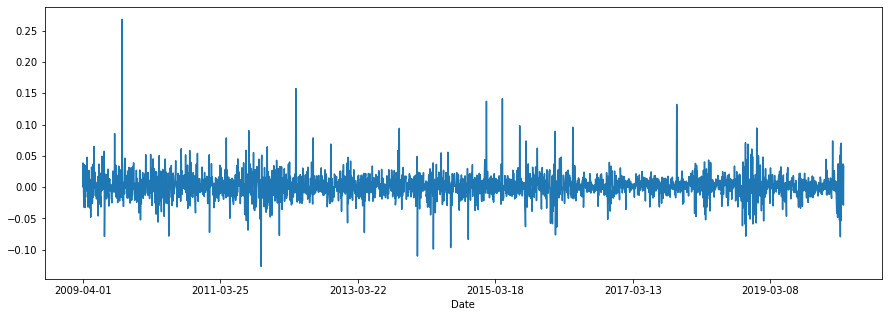

In [7]:

ret=ts['returns'].dropna()
ret.plot(figsize=(15, 5));

#ex. min stock lost 10% in a day,max stock gained 25% in a day

In [8]:
type(ret)

pandas.core.series.Series

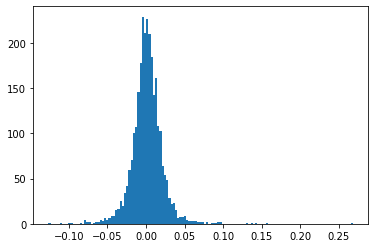

In [9]:
# Plot the distribution of returns
plt.hist(ret, bins='auto')  
plt.show()
#fairly normal return distribution, centered at 0

Transform the pandas series into a numpy array once we're comfortable with the data and data processing. 

In [10]:
ret.values

array([ 0.00081697,  0.0386394 ,  0.02397173, ...,  0.03693316,
       -0.02832539,  0.03360348])

In [11]:
# Convert data to to numpy array so we can use keras later
ret = ret.values
ret = ret.reshape(len(ret),1)
ret = ret.astype('float32')
print(ret.shape)
ret
#array of 2 dim, essentially a vector of price changes

(2768, 1)


array([[ 0.00081697],
       [ 0.0386394 ],
       [ 0.02397173],
       ...,
       [ 0.03693316],
       [-0.02832539],
       [ 0.03360348]], dtype=float32)

Split the data into a training and test set. We are using 80 percent of the data as training set and 20% as the test set. Remember not to sample randomly from different points in the time series! 

In [141]:
train_size

2214

In [142]:
test_size

554

In [140]:
# Data partitining 
train_size  = int(len(ret) * 0.80)
test_size   = len(ret) - train_size
train, test = ret[:train_size], ret[train_size:]

Normalize the values to a range from 0 to 1. 

In [13]:
train

array([[ 0.00081697],
       [ 0.0386394 ],
       [ 0.02397173],
       ...,
       [ 0.01781836],
       [ 0.02233911],
       [-0.00026047]], dtype=float32)

In [143]:
#since we work with NN, we scale our data, fitted values are min and max
# Scaling the data to the interval [0,1]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(train)

train = scaler.transform(train)
test  = scaler.transform(test)

Structure the data into convenient input and output for model training.

In [144]:
# we are stacking our values to create our input matrix =input data 
#from raw time series. appr. 3000 observation from one data
#there are also libraries you could use in keras to produce that operation
#youll need to decide on number of timestep-- critical decision when setting up ML time series model or LSTM model
#400 can be regarded as upper bound for seq length for LSTM

def create_dataset(time_series, timesteps):
    dataX, dataY = [], []
    
    for i in range(0, len(time_series)-timesteps ): # The last 
        x = time_series[i:(i+timesteps)]    ####### Remember Python's x[a, b-1]
        dataX.append(x)
        y = time_series[(i+timesteps)]      ##### Remember Python's x[b]
        dataY.append(y)
           
    return np.array(dataX), np.array(dataY)  #dont forget to convert to np.arrays

You can see that we will have to define the **timesteps** parameter, that is - how many steps back in time should be used to predict the target value. You can imagine that this hyperparameter can have quite an influence on the performance of your NN. Let's try to see if the partial autocorrelation plot can give us any hints.

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


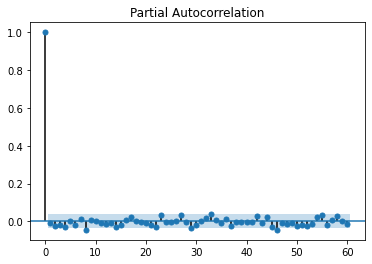

In [16]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(ret, lags=60) # how many observations in time should be depicted
plt.show()

#plot to look for some significant lags and make a dec for window. certain lag values display some autocorrelation
#trying to spot for positive or negative spikes. 


In this case, it is hard to grasp some particularly handy time span. Since we rather use a shorter time span, which will reduce computational cost, we select a value of 8. It represents  the correlation between values 8 time periods apart conditional on knowledge of the values in between. The PACF shows this lag to have an elevated effect. In general, past days with large, significant partial autocorrelation are the values to try out.

In [207]:
train.shape

(2214, 1)

In [208]:
timesteps = 8 # parameter to tune, timesteps

# The LSTM input layer must be 3D
# Create the dataset with rolling window for the training set and test set
X_train, y_train  = create_dataset(train, timesteps)  # lookback
X_test, y_test    = create_dataset(test, timesteps)
X_train.shape
#3d structure should become familair, 2206 samples, 8 time step (window size), which is our seq for one feature
# each observation is a sequence
#2206 seq of length 8 for 1 feature

(2206, 8, 1)

In [156]:
X_train[1]

array([[0.4187572 ],
       [0.38157862],
       [0.31498006],
       [0.24021506],
       [0.37016195],
       [0.41268325],
       [0.29444322],
       [0.2655882 ]], dtype=float32)

In [150]:
y_train[0]

array([0.2655882], dtype=float32)

we could have made use of some functionality in, e.g., Keras to create our input data. The following example illustrates the use of the Keras *TimeseriesGenerator*, which provides corresponding functionality. We only demonstrate it for the training data. 



In [20]:
train[:10]

array([[0.3228875 ],
       [0.4187572 ],
       [0.38157862],
       [0.31498006],
       [0.24021506],
       [0.37016195],
       [0.41268325],
       [0.29444322],
       [0.2655882 ],
       [0.23842642]], dtype=float32)

In [154]:
from keras.preprocessing.sequence import TimeseriesGenerator
# class time series generator, also there is such a function in SKlearn
#redo work from custom dataset
# Create input data from time series
#put in train data 2, once as actual train data, once as target variable, specify window length and pick sampling rate
# sampling rate determins how much data is shifted
demo = TimeseriesGenerator(train, train, length = timesteps, sampling_rate=1, batch_size=1)
print('Length of the output is {}.'.format(len(demo)))


Length of the output is 2206.


In [155]:
# As result, we get a set of tuples (x, y) which we can enumerate and index
demo[0]

(array([[[0.3228875 ],
         [0.4187572 ],
         [0.38157862],
         [0.31498006],
         [0.24021506],
         [0.37016195],
         [0.41268325],
         [0.29444322]]], dtype=float32), array([[0.2655882]], dtype=float32))

In [23]:

# As result, we get a set of tuples (x, y) which we can enumerate and index
demo_x0 = demo[0][0] # our first sequence
demo_y0 = demo[0][1] # our first target 
print(demo_x0)
print(X_train[0])   # Compare that to the above

# Likewise
print(demo_y0)
print(y_train[0])

# Here is an example to transform the output of TimeseriesGenerator to match the structure of X_train
demo_x = np.asarray([x[0] for x in demo])
demo_x = np.reshape(demo_x, (len(demo), timesteps, 1))
print('Shape of demo_x {}'.format(demo_x.shape))

# Confirm the two data structures are equivalent
print('Difference of the two data containers should be zero and evaluates to {}'.format(
    np.sum(demo_x - X_train)))


[[[0.3228875 ]
  [0.4187572 ]
  [0.38157862]
  [0.31498006]
  [0.24021506]
  [0.37016195]
  [0.41268325]
  [0.29444322]]]
[[0.3228875 ]
 [0.4187572 ]
 [0.38157862]
 [0.31498006]
 [0.24021506]
 [0.37016195]
 [0.41268325]
 [0.29444322]]
[[0.2655882]]
[0.2655882]
Shape of demo_x (2206, 8, 1)
Difference of the two data containers should be zero and evaluates to 0.0


According to Keras, expected input data shape: (number of observations, timesteps, features (1=univariate, n=multivariate ts).


In [24]:
X_train.shape

(2206, 8, 1)

In [25]:
# Reshape input to be [obs, time steps, features]
#X_train  = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#X_test   = np.reshape(X_test,  (X_test.shape[0],  X_test.shape[1],  1))
print(X_train.shape,y_train.shape, X_test.shape,y_test.shape)


(2206, 8, 1) (2206, 1) (546, 8, 1) (546, 1)


Let's look at the first two observations and within each observation at the last 5 time steps. Notice how the values in the second observation are the observations of the first shifted by 1, with the first y now being the last observed value. 

In [26]:
X_train[0:2,-5:,:]

array([[[0.31498006],
        [0.24021506],
        [0.37016195],
        [0.41268325],
        [0.29444322]],

       [[0.24021506],
        [0.37016195],
        [0.41268325],
        [0.29444322],
        [0.2655882 ]]], dtype=float32)

In [27]:
y_train[0:2]

array([[0.2655882 ],
       [0.23842642]], dtype=float32)



For evaluation, we use **RMSE**. It penalizes large errors and the scores are easier to interpret as the units are not squared. 

In [157]:
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_score):
    error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
    return error

In [158]:
rmse_train = {}
rmse_test = {}

In [159]:
# We use one dictionary for the training and one for the test data
#were we collect different perf statistics and data pieces we ll need later for training and test set
pred_test = {}
pred_train = {}

# We store the actual price differences as opposed to their scaled version
#score true values of train and test, we have scaled them, but when analyzing model perf
# iits better to use original prices, so we revert our scaling so that forecast and actuals represent perc changes i can interpret easier

pred_train["true"] = scaler.inverse_transform(y_train).flatten()  # faltten just means store as 1d array, while it comes put as a numeric vector
pred_test["true"]  = scaler.inverse_transform(y_test).flatten() 



In [33]:
#always good idea to put togetehr results that are central to your analysis in a dict for example
#using dict pred_train you can easily convert into dataframe and plot for example

## LSTM in Keras 

In [34]:
import keras
#we import keras and layers, the new LSTM layer, we ll play with Dropout
#we can build LSTM in same way as feedforward NN, exchanging Dense Layer with LSTm layer

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
#subtle details that make it a bit harder, specially when we work with time series data
#arguments to decide on 

### Stateless LSTM
Let's not worry too much for start and just define and train a first LSTM.

In [35]:
X_train.shape

(2206, 8, 1)

In [36]:
# Define the model, first model , looks like normal NN
#input shape will be determined from train data, will work only for stateless models
batch_size = 32 # An arbitrary choice, dnt worry about it now
stateless = Sequential()
stateless.add(LSTM(10, activation='relu',input_shape=(8, 1)))  # size of the LSTM hidden state
stateless.add(Dense(1)) # NO SOFTMAX Layer cause you do not want a probability as OUTPUT! But the actual Logits/Values
stateless.compile(loss = 'mean_squared_error', optimizer = "adam", metrics=['mse'])

# Training
stateless.fit(X_train, y_train, batch_size=batch_size, epochs=10, validation_split=0.3, verbose=1)
stateless.summary()
#traoi for 10 epochs, validation data--debatable to set it here, you should have validation data that comes after train data in time
#random sample doesnt make much sense for validation data,but bcs its a stateless LSTM we coundt on fact that all info is in window size
#so uzing random split to validate data is not that bad
#we see how loss develops

Epoch 1/10
49/49 [==============================] - 2s 13ms/step - loss: 0.0295 - mse: 0.0295 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 2/10
49/49 [==============================] - 0s 7ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 3/10
49/49 [==============================] - 0s 7ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 4/10
49/49 [==============================] - 0s 7ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 5/10
49/49 [==============================] - 0s 7ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 6/10
49/49 [==============================] - 0s 6ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 7/10
49/49 [==============================] - 0s 6ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 8/10
49/49 [==============================] - 0s 7ms/step - loss: 0.0033 - mse: 0.0

In [37]:
# values 10 come from 10 units in lstm layer,
# 480 param: input to lstm gate has dim 11 (10 prev hidden unit cell +1 new current input)
# vector of size 11 is inputted to 4 LSTM gates of dim 10 = 11*4*10 +4*10 biases for each gate = 480


We can use this trained network for prediction; provided we remember to comply with the input data requirements.

In [164]:
X_test[0].shape

(8, 1)

In [38]:
X_test[0].reshape(1, timesteps, 1).shape

(1, 8, 1)

In [39]:
X_test.shape

(546, 8, 1)

In [165]:
# Input data for prediction as 3d array [samples / time steps / features]
#predict also wants to see input data in 3d format

stateless.predict(X_test[0].reshape(1, timesteps, 1))

array([[0.3335095]], dtype=float32)

In [42]:
X_test[0].reshape(1, timesteps, 1)
# here we have the scaled version

array([[[0.3016634 ],
        [0.3175283 ],
        [0.32328618],
        [0.38490084],
        [0.38809454],
        [0.31145936],
        [0.35898203],
        [0.36514872]]], dtype=float32)

In [43]:
# Compare to actual
y_test[0]

array([0.34907383], dtype=float32)

Let's try out one of the arguments of the LSTM layer, the *return_sequences* argument. As said, it should allow us to obtain LSTM outputs, predictions, for each processing step. Note that we will not train the new model now (for simplicity). This means that forecasts will result from random weights. The purpose of the demo is to sketch what happens if setting *return_sequences* to True.

In [166]:
# Define the model
#lets play with return seq
demo = Sequential()
demo.add(LSTM(10, return_sequences=True))
demo.add(Dense(1))

#input one datapoint, first datapoint of testset
demo.predict(X_test[0].reshape(-1, timesteps, 1))
#compared to before where we got a scalar value, nor we get interreguonal forecasts for timesteps in our window (8 being the window size)
# one forecast for each part of the input seq. 
#new demo thats not trained, based on randomly initialized weights. Just to show parameter

array([[[-0.00556986],
        [-0.01388492],
        [-0.02312919],
        [-0.0331961 ],
        [-0.04318902],
        [-0.05121367],
        [-0.05808323],
        [-0.06429964]]], dtype=float32)

In [45]:
y_train[0]

array([0.2655882], dtype=float32)

In [46]:
timesteps

8

In [47]:
# we cant train it bcs input data is not in right shape for return seq = true
#  you d need target data you feed into lstm, you d need to configure network as a many to many LSTM


If we try training the demo LSTM as above we get an error because our labels are not in the right format for training with return_sequences equal to True. That makes sense because y_train is currently an array of dimension (sample size, target value) while we would need a sequence of target values for each time step. Read this post if you want to explore [multi-step forecasting using LSTMs](https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/). 

Back to our first proper LSTM. We compute train and test set forecasts and store these for later comparisons.

In [169]:
pred_train

{'stateless': array([ 0.0062937 ,  0.00415016, -0.00023204, ...,  0.00405309,
         0.00594605,  0.00670762], dtype=float32),
 'true': array([-0.02178871, -0.03250455,  0.03399813, ...,  0.01781835,
         0.02233911, -0.00026047], dtype=float32)}

In [167]:
# Remember that we need to reverse the scaling. This is equivalent to the above code for the persistence benchmark
pred_train["stateless"] = scaler.inverse_transform(
                              stateless.predict(X_train,verbose=0)
).flatten()

pred_test["stateless"] = scaler.inverse_transform(stateless.predict(X_test,verbose=0)).flatten()

Train Score of stateless LSTM: 0.020989 RMSE
Test Score of stateless LSTM:  0.020958 RMSE


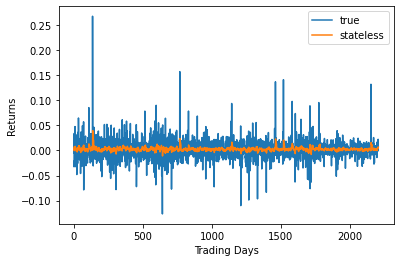

In [168]:
# Compute RMSE
rmse_train["stateless"] = rmse(pred_train["true"], pred_train["stateless"])
rmse_test["stateless"]  = rmse(pred_test["true"],  pred_test["stateless"])

print('Train Score of stateless LSTM: %.6f RMSE' % (rmse_train["stateless"]))
print('Test Score of stateless LSTM:  %.6f RMSE' % (rmse_test["stateless"]))

# Plot actuals and forecasts
pd.DataFrame(pred_train)[["true","stateless"]].plot()
plt.xlabel('Trading Days')
plt.ylabel('Returns')
plt.show()

In [50]:
# looking at plot of stateless model its hard to see at this resolution, but underestimates spikes,
#but gets timing of spikes not to wrong

It is always wise to also examine predictions at a lower scale.

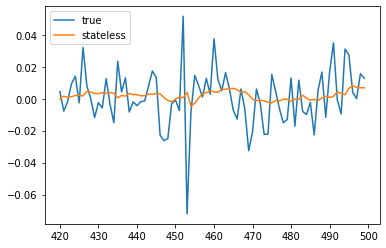

In [51]:
pd.DataFrame(pred_train).iloc[420:500,:].plot();
#doesnt look like a great forecast

### Multiple layers
We discussed stacked LSTMs in the lecture. For this univariate time series, it is questionable whether a stacked LSTM does any better than one with only one LSTM layer. For example, [Fischer and Kraus (2019)](https://www.sciencedirect.com/science/article/abs/pii/S0377221717310652?via%3Dihub) report some very nice results from forecasting all stocks of the S&P 500 using a relatively simple LSTM. Nonetheless, developing stacked LSTMs using Keras is illustrative to better understand the way we need to input data and configure the network. Hence, let's build a network with two LSTM layers. 

In [170]:
# stacking, for univariate time serie syou would not need stacking much, but lets try it out
stateless_multilayer = Sequential()
stateless_multilayer.add(LSTM(7, return_sequences=True)) # need to set it to True, otherwise we d lack input to second LSTM layer. 
#Input to next LSTM is output of prev layer. For every time step we need an input
#stateless_multilayer.add(Dropout(0.2))  # you can also add dropout layers if you like
stateless_multilayer.add(LSTM(7, return_sequences=False)) #return seq can be False in last LSTM layer
#stateless_multilayer.add(Dropout(0.2))
stateless_multilayer.add(Dense(1)) # NO SOFTMAX Layer cause you do not want a probability as OUTPUT! But the actual Logits/Values
stateless_multilayer.compile(loss = 'mean_squared_error', optimizer = "adam", metrics=['mse'])

Make sure to examine the above architecture carefully. The first layer uses *return_sequences=True*. Hence, we get one output value for each time step. These outputs can then be used as input for the second LSTM layer. This is the only way to do it. If you want to develop a stacked LSTM, you have to use *return_sequences=True* to get an input for the second layer; same when you make your network deeper and add more layers. The output of one layer is the input of the next layer.

Also note how we set *return_sequences=False* in the top layer. This means that we only get one forecast for the target variable from the last hidden state after processing the full sequence. Therefore, we do not need to adjust our target in any way and can train right with the 2d array *y_train* as follows. 

In [171]:
#y train is a vector of numbers, so output of last Lstm layer can be ret seq = false
y_train.shape

(2206, 1)

In [172]:
X_train.shape

(2206, 8, 1)

In [173]:
# run tutorials yourself, play with parameters etc 

In [174]:
stateless_multilayer.fit(X_train, y_train, batch_size=batch_size, epochs=10, validation_split=0.3);

Epoch 1/10
1544/1544 [==============================] - 16s 8ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 2/10
1544/1544 [==============================] - 11s 7ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 3/10
1544/1544 [==============================] - 11s 7ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 4/10
1544/1544 [==============================] - 11s 7ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 5/10
1544/1544 [==============================] - 11s 7ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 6/10
1544/1544 [==============================] - 11s 7ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 7/10
1544/1544 [==============================] - 11s 7ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 8/10
1544/1544 [==============================] -

To complete the part on the stacked LSTM, we proceed as above to produce some error metrics and a plot.

In [175]:
stateless_multilayer.predict(X_test,verbose=0).shape

(546, 1)

In [177]:
# Error assessment of the stacked LSTM
pred_train["stateless_multilayer"] = scaler.inverse_transform(
                              stateless_multilayer.predict(X_train,verbose=0)
).flatten()

pred_test["stateless_multilayer"] = scaler.inverse_transform(
                              stateless_multilayer.predict(X_test,verbose=0)
).flatten()

rmse_train["stateless_multilayer"] = rmse(pred_train["true"], pred_train["stateless_multilayer"])
rmse_test["stateless_multilayer"] = rmse(pred_test["true"], pred_test["stateless_multilayer"])

print('Train Score: %.6f RMSE' % (rmse_train["stateless_multilayer"]))
print('Test Score: %.6f RMSE' % (rmse_test["stateless_multilayer"]))


Train Score: 0.021133 RMSE
Test Score: 0.020886 RMSE


In [255]:
rmse_train

{'stateful': 0.020653117,
 'stateful_new': 0.020444557,
 'stateless': 0.020989168,
 'stateless_multilayer': 0.021133289}

In [256]:
results_train = pd.DataFrame.from_dict(rmse_train, orient='index',columns=['rmse_train'])
results_test = pd.DataFrame.from_dict(rmse_test, orient='index',columns=['rmse_test'])
results = results_train.join(results_test)
results

,rmse_train,rmse_test
stateless,0.020989,0.020958
stateless_multilayer,0.021133,0.020886
stateful,0.020653,0.020627
stateful_new,0.020445,0.020561


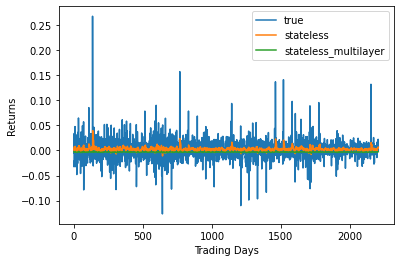

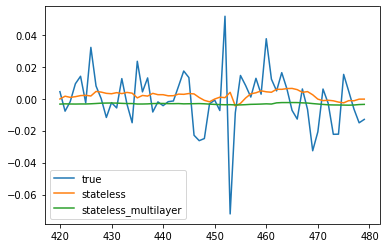

In [179]:
# Plot of forecasts and actuals
pd.DataFrame(pred_train)[["true","stateless","stateless_multilayer"]].plot()
plt.xlabel('Trading Days')
plt.ylabel('Returns')
plt.show()

# and again for a specific time interval 
pd.DataFrame(pred_train)[["true","stateless","stateless_multilayer"]].iloc[420:480,:].plot()
plt.show()
# output at higher resolution
# stateless multilayer seems to be biased upwards, not know why, didnt bring us much further in forecasting

In [89]:
print(rmse_train)
print(rmse_test)

{'stateless': 0.020989168, 'stateless_multilayer': 0.020775978}
{'stateless': 0.02095751, 'stateless_multilayer': 0.020620234}


In [ ]:
# for time series you want to use stateful LSTM. 
# why? cons of notr making LSTM stateful: 

### Stateful LSTM


In Keras, the **difference between a stateful and a stateless LSTM concerns the point when the hidden state is reset**. 
The maybe more common case is a **stateless LSTM: there, the hidden state is reset after processing one batch** it is the clear choice when every observation does not depend on the previous one (e.g., sentence classification). **Stateful** LSTM  is one for which the internal states (memories) obtained after processing a **batch of samples are reused as initial states for the samples of the next batch**. in Time Series this enables us to forward the hidden state through all time steps.  BUT The **hidden state is passed from batch to batch, not within the batch**. Within a batch the sub-sequences are treated as independent.**

When enabling stateful training, you can manange the transition between observations correctly. If we don't, we will start a sequence with the hidden state at another period of time! Note that that is done in most applications however. https://stackoverflow.com/questions/58276337/proper-way-to-feed-time-series-data-to-stateful-lstm

In [ ]:
#we feed subseq into LSTM, dont worry about batch size now. 
#from h3, last hidden state you pull out a forecast
#in a stateless mode, tehse hidden states are not maintained
#in next batch hidden state is initialized again with hidden number

Remember that this is what our data looks like. For the sake of the visualization, we'll go with a small window size of 4 but leave the batch size to be determined. 

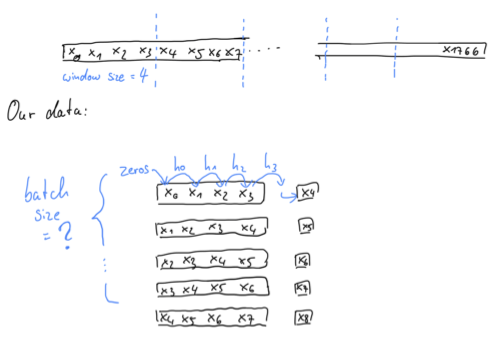

In [91]:
# if we state stateful=true, hiddenftate is transfereed to next batch. 
#you initialize hidden state with prev hidden state h3
# we wouldnt want to do that, to process x1 in second mini batch. 
#what would we like to have?

Now let's assume a batch size of 1, the smallest possible, and see what happens during training:

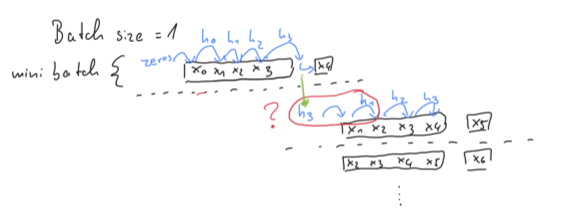

We update the hidden state with the first four inputs $x_0, x_1, x_2, x_3$. We then use the last hidden state, $h_3$, to make a prediction for the next period. So far, the procedure is identical to the stateless RNN. 

We initialize the hidden state for the next batch, $x_1, x_2, x_3, x_4$, not with zeros but with the hidden state from the last batch, $h_3$. Oh no, that doesn't look right! We would like to **start with the hidden state after the first period, $h_0$, instead we are starting with $h_3$!**

Well, what would we need to change to start with $h_0$ before we process input $x_1$ etc.? 
We have control over three things: **The window size, the batch size and the structure of the data.** 

We determined the window size empirically, so we might not want to change it arbitrarily.
However, we could change the batch size! Try different batch sizes and you'll see that for the way we structured the data, the state forwarding works as expected when the batch size is equal to the window size. Note in particular that the state for the n-th observation in a batch is transferred to the n-th observation in the next batch. 

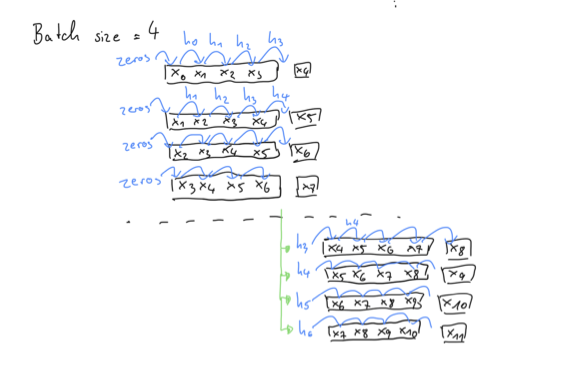

For time series forecasting, there are many suggestions what should be the batch size for an LSTM.

The Keras implementation enforces a **constant batch size for training and prediction** . So one of the rules observed (according to Keras functionality)  is batch size is the same as your output.

Thus, if you want to make prediction one day into the future, a common setting in stock prediction settings, then you should train your LSTM with batch size=1. 
Conversely, if you train your LSTM with batch size equal to, say, 10, you must provide exactly ten samples to the .predict() function. In practice, it implies that you would need to wait for ten days before you can make a prediction.

 

There are ways to get round this issue. One is to use Tensorflow but you can [also persuade Keras to let you change the batch size from training to prediction].(https://machinelearningmastery.com/use-different-batch-sizes-training-predicting-python-keras/)

## Batch Size 1

In [180]:
batch_size = 1

In [181]:
stateful = Sequential()
#now that stateful TRue, we NEED to specify input size of our batch!!
# if stateful, batch size has to be specified instead of input shape
stateful.add(LSTM(7,stateful=True, batch_input_shape=(batch_size, timesteps, 1), ))
stateful.add(Dense(1))
stateful.compile(loss = 'mean_squared_error', optimizer = "adam", metrics=['mse'])

Training

We'll use a custom training loop over epochs to reset the hidden states manually after each epoch. In case you are using a stateful LSTM, make sure you reset the state after every epoch, otherwise the NN will treat it as a continuation of the time series. 

And make sure to set shuffle to False , more explanation: https://stackoverflow.com/questions/57041305/keras-shuffling-dataset-while-using-lstm

In [182]:
#train lstm more manual now, with 10 epochs, each time i call fit, 
#hidden state will not be eraised since we have stateles=true, accumulates information
#data we put in, will look like endless time series
#after 1 epoch we saw entire train set 
#if we dont reset state, in next training otherwise, time series from prev epoch goes on, thats not what we want
for i in range(10):
    stateful.fit(X_train, y_train, batch_size=batch_size, epochs=1,
          #validation_split=0.3, # We cannot afford validation data to be sampled automatically as this would break the data ordering, need to manually split train data into test 
          shuffle=False) # don't shuffle, we must keep the order of observations for the batches to match
          # shuffle happens on the batches axis, not on the time axis
    stateful.reset_states()
#training takes longer for stateful lstm

2206/2206 [==============================] - 8s 4ms/step - loss: 0.0028 - mse: 0.0028


In [183]:
# Performance evaluation is ALMOST as usual , we need to specify batch_size
pred_train["stateful"] = scaler.inverse_transform(
                              stateful.predict(X_train,verbose=0, batch_size=batch_size)
).flatten()

# However, there is one important bit
stateful.reset_states()

In [184]:
X_train.shape

(2206, 8, 1)

In [185]:
# Performance evaluation is ALMOST as usual , we need to specify batch_size
pred_test["stateful"] = scaler.inverse_transform(
                              stateful.predict(X_test,verbose=0, batch_size=batch_size)
).flatten()

# However, there is one important bit
stateful.reset_states()

Why do we need to reset_states()? Having set `stateful=True`, the model will never reset its state automatically. 

In [187]:
rmse_train["stateful"] = rmse(pred_train["true"], pred_train["stateful"])
print('Train Score: %.6f RMSE' % (rmse_train["stateful"]))
rmse_test["stateful"] = rmse(pred_test["true"], pred_test["stateful"])
print('Test Score: %.6f RMSE' % (rmse_test["stateful"]))

Train Score: 0.020653 RMSE
Test Score: 0.020627 RMSE


In [260]:
pd.DataFrame(pred_train).plot()

plt.legend()
plt.show()

ValueError: ignored

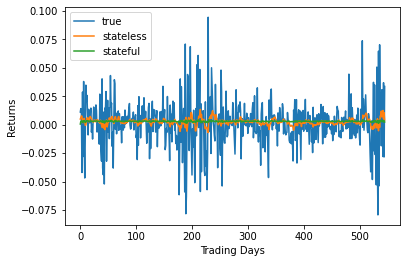

In [189]:
pd.DataFrame(pred_test)[["true","stateless","stateful"]].plot()
plt.xlabel('Trading Days')
plt.ylabel('Returns')
plt.show()

And a closer look at the beginning of the test set:

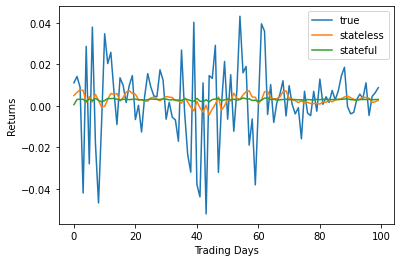

In [193]:
pd.DataFrame(pred_test)[["true","stateless","stateful"]].iloc[0:100,:].plot()
plt.xlabel('Trading Days')
plt.ylabel('Returns')
plt.show()

## use Batch Size = Time step = 8

In [194]:
batch_size = timesteps

In [195]:
stateful_new = Sequential()
#now that stateful TRue, we NEED to specify input size of our batch!!

stateful_new.add(LSTM(7,stateful=True, batch_input_shape=(batch_size, timesteps, 1), ))# if stateful, batch size has to be specified instead of input shape
stateful_new.add(Dense(1))
stateful_new.compile(loss = 'mean_squared_error', optimizer = "adam", metrics=['mse'])

In [196]:
y_train.shape

(2206, 1)

Training

In [262]:
X_train.shape

(2206, 8, 1)

In [263]:
y_train.shape

(2206, 1)

In [197]:
for i in range(10):
    stateful_new.fit(X_train, y_train, batch_size=batch_size, epochs=1,
          #validation_split=0.3, # We cannot afford validation data to be sampled automatically as this would break the data ordering, need to manually split train data into test 
          shuffle=False) # don't shuffle, we must keep the order of observations for the batches to match
    stateful_new.reset_states()
#training takes longer for stateful lstm

265/276 [===========================>..] - ETA: 0s - loss: 0.0380 - mse: 0.0380

InvalidArgumentError: ignored

If you complete the image of the batch ordering until the end of the data, you'll notice that the last batch might be smaller than previous batches. Why? Because if the data is not equally divisible, we'll have some observations left over at the very end. Normally, that's not a problem and we work with a smaller batch at the end of each epoch. However, the stateful implementation requires us to specify and fix the batch size before training. 

To fix this issue, we will drop observations from the start of the time series until the data is nicely devisible into equal size batches.

In [211]:
# The modulo % is the remainder after devision
#train and test will be split in batches, but our dataset might not be divided by batch size
# in order to make sure some obs in the end get discarded
# just check if we divide train and test by batch size, 
rest = len(y_train) % batch_size
rest

6

In [264]:
X_train.shape

(2206, 8, 1)

In [212]:
#discard 6 first el. from train set, 
X_train_new, y_train_new = X_train[rest:,:], y_train[rest:,:]

In [213]:
len(y_train_new) % batch_size

0

In [204]:
for i in range(10):
    stateful_new.fit(X_train_new, y_train_new, batch_size=batch_size, epochs=1,
          #validation_split=0.3, # We cannot afford validation data to be sampled automatically as this would break the data ordering, need to manually split train data into test 
          shuffle=False) # don't shuffle, we must keep the order of observations for the batches to match
    stateful_new.reset_states()

275/275 [==============================] - 1s 4ms/step - loss: 0.0028 - mse: 0.0028


In [214]:
# Performance evaluation is ALMOST as usual , we need to specify batch_size
pred_train["stateful_new"] = scaler.inverse_transform(
                              stateful_new.predict(X_train_new,verbose=0, batch_size=batch_size)
).flatten()

# However, there is one important bit
stateful_new.reset_states()

In [216]:
# pred on test set 
stateful_new.predict(X_test, verbose=0, batch_size=batch_size)


InvalidArgumentError: ignored

In [202]:
#same issue in KERAS that batch size btw. train and test must remain same
#need to make sure our test data divides evenly by 8, so that no obs gets discarded
len(y_test) % batch_size

2

In [231]:
len(X_test) % batch_size

2

In [239]:
#same issue occured that batch size btw. train and test must remain same
#need to make sure our test data divides evenly by 8, so that no obs gets discarded
# copy obs from train into test until it dived evenly by batch size
X_test_extended = np.vstack([X_train[-6:,:], X_test])

In [240]:
X_test.shape

(546, 8, 1)

In [241]:
X_test_extended.shape

(552, 8, 1)

In [242]:
X_test_extended.shape[0] % batch_size

0

In [243]:
pred_test_extended = stateful_new.predict(X_test_extended, verbose=0, batch_size=batch_size)



In [247]:
len(pred_test_extended[-len(y_test):])

546

In [248]:
pred_test["stateful_new"] = scaler.inverse_transform(
                              pred_test_extended[-len(y_test):]
).flatten()

In [249]:
rmse_train["stateful_new"] = rmse(pred_train["true"][:-rest], pred_train["stateful_new"])
print('Train Score: %.6f RMSE' % (rmse_train["stateful_new"]))
rmse_test["stateful_new"] = rmse(pred_test["true"], pred_test["stateful_new"])
print('Test Score: %.6f RMSE' % (rmse_test["stateful_new"]))

Train Score: 0.020445 RMSE
Test Score: 0.020561 RMSE


In [250]:
rmse_test

{'stateful': 0.02062719,
 'stateful_new': 0.020560741,
 'stateless': 0.02095751,
 'stateless_multilayer': 0.020886483}

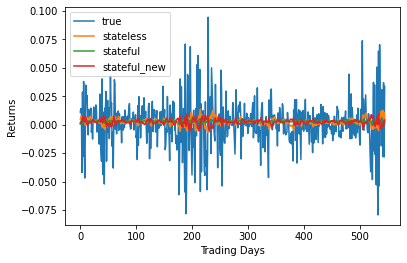

In [252]:
pd.DataFrame(pred_test)[["true","stateless","stateful", "stateful_new"]].plot()
plt.xlabel('Trading Days')
plt.ylabel('Returns')
plt.show()

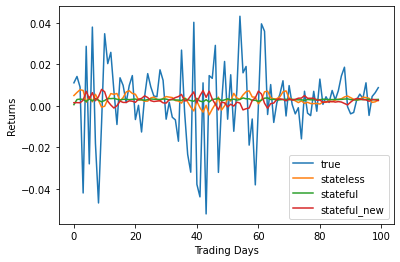

In [254]:
pd.DataFrame(pred_test)[["true","stateless","stateful","stateful_new"]].iloc[0:100,:].plot()
plt.xlabel('Trading Days')
plt.ylabel('Returns')
plt.show()